In today's energy-conscious world, understanding and optimizing household electricity usage is more important than ever. This project leverages four years of detailed power consumption data from homes to build machine learning models that predict future energy needs.

## The Data

Available in `df_train.csv` and `df_test.csv`:

| Column             | Type   | Description                                                                 |
|--------------------|--------|----------------------------------------------------------------------------|
| date               | chr    | Date of the measurement                                                    |
| power_consumption  | dbl    | Daily power consumption (in kilowatts)                                     |
| year               | int    | Year of the measurement                                                    |
| semester           | int    | Semester of the measurement (1 for Jan-Jun, 2 for Jul-Dec)                 |
| quarter            | int    | Quarter of the measurement (1 for Q1, 2 for Q2, 3 for Q3, 4 for Q4)        |
| day_in_week        | chr    | Day of the week of the measurement (e.g., Monday, Tuesday)                 |
| week_in_year       | int    | Week number in the year of the measurement                                 |
| day_in_year        | int    | Day number in the year of the measurement                                  |
| month              | int    | Month of the year of the measurement                                       |

This dataset was donated to the UCI Machine Learning Repository.

In [1]:
# install packages (if needed)

install.packages(c("dplyr", "lubridate", "ranger", "xgboost", "ggplot2"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’




## Load the necessary libraries

In [2]:
# Suppress verbose package startup messages (keeps output clean)
suppressPackageStartupMessages({
  library(dplyr)      # Data manipulation (filter, mutate, select, etc.)
  library(lubridate)  # Date/time handling (parsing, extraction, arithmetic)
  library(ranger)     # Efficient Random Forest implementation
  library(xgboost)    # Gradient Boosting (XGBoost) for high-performance modeling
  library(ggplot2)    # Advanced data visualization (plots, themes, scales)
})

# Check for missing packages and install them if needed
required_packages <- c("dplyr", "lubridate", "ranger", "xgboost", "ggplot2")
missing_packages <- required_packages[!required_packages %in% installed.packages()]

if (length(missing_packages)) {
  message("Installing missing packages: ", paste(missing_packages, collapse = ", "))
  install.packages(missing_packages)
}

In [3]:
# # For additional functionality:
# install.packages(c("tidyr", "caret", "plotly"))
# library(tidyr)    # Data tidying (pivot_longer, pivot_wider)
# library(caret)    # Unified ML workflow (preprocessing, tuning)
# library(plotly)   # Interactive visualizations

## Load and inspect the data

In [4]:
# The data is available in df_train.csv and df_test.csv files
df_train <- read.csv("df_train.csv") # Load training dataset
df_test <- read.csv("df_test.csv")   # Load test dataset

### Explore the structure of df_train

In [5]:
# Displays structure
glimpse(df_train)

Rows: 1,202
Columns: 9
$ date              <chr> "12/16/2006", "12/17/2006", "12/18/2006", "12/19/200…
$ power_consumption <dbl> 1209.176, 3390.460, 2203.826, 1666.194, 2225.748, 17…
$ year              <int> 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006…
$ semester          <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1…
$ quarter           <int> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1…
$ day_in_week       <chr> "Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sa…
$ week_in_year      <int> 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, …
$ day_in_year       <int> 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 36…
$ month             <int> 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, …


In [6]:
# Displays first rows
head(df_train)

date       power_consumption year semester quarter day_in_week week_in_year
1 12/16/2006 1209.176          2006 2        4       Sat         50          
2 12/17/2006 3390.460          2006 2        4       Sun         51          
3 12/18/2006 2203.826          2006 2        4       Mon         51          
4 12/19/2006 1666.194          2006 2        4       Tue         51          
5 12/20/2006 2225.748          2006 2        4       Wed         51          
6 12/21/2006 1716.624          2006 2        4       Thu         51          
  day_in_year month
1 350         12   
2 351         12   
3 352         12   
4 353         12   
5 354         12   
6 355         12

## Data Preprocessing

In [7]:
# Convert 'date' column to Date type and 'day_in_week' to factor (categorical variable)
# This applies to both training and test sets
df_train <- df_train %>%
  mutate(date = as.Date(date, format = "%m/%d/%Y"),
         day_in_week = factor(day_in_week))
df_test <- df_test %>%
  mutate(date = as.Date(date, format = "%m/%d/%Y"),
         day_in_week = factor(day_in_week))

# One-Hot Encoding for 'day_in_week'
# This converts the categorical variable 'day_in_week' into binary indicator variables
df_onehot_train <- model.matrix(~ day_in_week - 1, data = df_train) %>%
  as.data.frame()
df_onehot_test <- model.matrix(~ day_in_week - 1, data = df_test) %>%
  as.data.frame()

# Merge the encoded columns with the original datasets and remove the original 'day_in_week' column
df_train <- mutate(df_train, df_onehot_train) %>% select(-c(day_in_week))
df_test <- mutate(df_test, df_onehot_test) %>% select(-c(day_in_week))

## Separation of Features (X) and Target Variable (y)

In [8]:
# The target variable is 'power_consumption'
# 'power_consumption' and 'date' are excluded from the features
train_x <- df_train %>% select(-power_consumption, -date)
train_y <- df_train[["power_consumption"]]
test_x <- df_test %>% select(-power_consumption, -date)
test_y <- df_test[["power_consumption"]]

## Model Training and Evaluation using RMSE

In [9]:
## Model 1: Linear Regression
lm_model <- lm(train_y ~ ., data = train_x)
lm_pred <- predict(lm_model, newdata = test_x)
lm_rmse <- sqrt(mean((test_y - lm_pred)^2))
# A warning about rank-deficient fit may appear

## Model 2: Random Forest (Trained with 1000 trees)
rf_model <- ranger(power_consumption ~., data = df_train %>% select(-date), num.trees = 1000)
rf_pred <- predict(rf_model, data = df_test %>% select(-date))$predictions
rf_rmse <- sqrt(mean((test_y - rf_pred)^2))

## Model 3: XGBoost
# Configured with 500 rounds, squared error regression objective, and learning rate (eta) of 0.1
xgb_model <- xgboost(
  data = as.matrix(train_x),
  label = train_y,
  nrounds = 500,
  objective = "reg:squarederror",
  eta = 0.1,
  max_depth = 1,
  verbose = FALSE
)
xgb_pred <- predict(xgb_model, newdata = as.matrix(test_x))
xgb_rmse <- sqrt(mean((test_y - xgb_pred)^2))

## Results Comparison

In [10]:
# Display RMSE scores for all models
data.frame(
  Model = c("Linear Regression", "Random Forest", "XGBoost"),
  RMSE = c(lm_rmse, rf_rmse, xgb_rmse)
)

# Identify and display the lowest RMSE (best model)
selected_rmse <- min(lm_rmse, rf_rmse, xgb_rmse)
cat("selected_rmse:", selected_rmse, "kW\n")

Model             RMSE    
1 Linear Regression 504.2986
2 Random Forest     392.7394
3 XGBoost           403.5540

selected_rmse: 392.7394 kW


## Results Visualization and Analysis

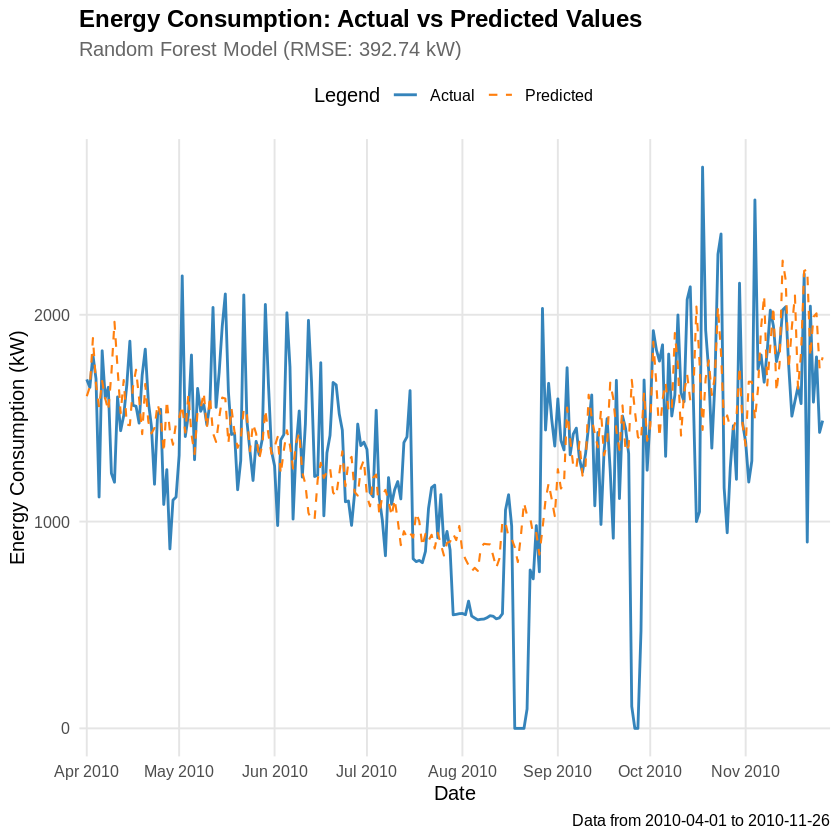


Model Performance Metrics: 
● RMSE: 392.74 
● Correlation: 0.595 
● Trend Similarity: Moderate 


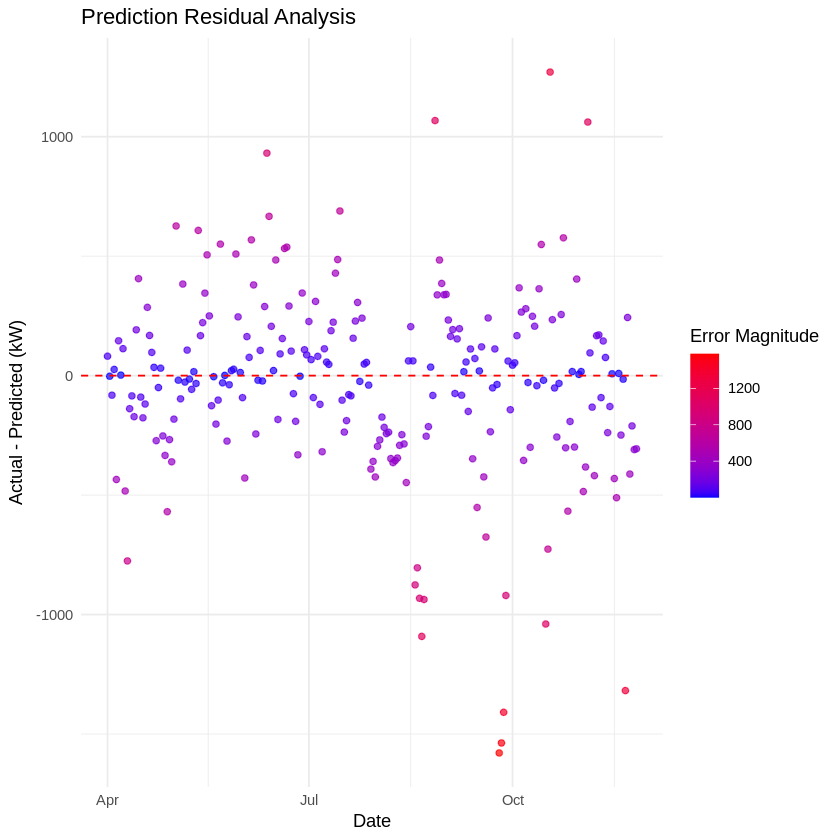

In [11]:
# Add predictions to test data and calculate residuals
df_test <- df_test %>%
  mutate(
    Predicted = rf_pred,
    Residual = power_consumption - Predicted,
    Prediction_Error = abs(Residual)
  )

# Create a custom color palette
colors <- c("Actual" = "#1f77b4", "Predicted" = "#ff7f0e")

# Main Visualization: Actual vs Predicted
consumption_plot <- ggplot(df_test) +
  geom_line(aes(x = date, y = power_consumption, color = "Actual"),
            linewidth = 0.8, alpha = 0.9) +
  geom_line(aes(x = date, y = Predicted, color = "Predicted"),
            linewidth = 0.6, linetype = "dashed") +
  scale_color_manual(values = colors) +
  labs(
    title = "Energy Consumption: Actual vs Predicted Values",
    subtitle = paste("Random Forest Model (RMSE:", round(rf_rmse, 2), "kW)"),
    x = "Date",
    y = "Energy Consumption (kW)",
    color = "Legend",
    caption = paste("Data from", min(df_test$date), "to", max(df_test$date))
  ) +
  scale_x_date(
    date_breaks = "1 month",
    date_labels = "%b %Y",
    expand = c(0.01, 0.01)
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "top",
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank(),
    plot.title = element_text(face = "bold"),
    plot.subtitle = element_text(color = "grey40")
  )

# Residual Analysis Plot
residual_plot <- ggplot(df_test, aes(x = date, y = Residual)) +
  geom_point(aes(color = Prediction_Error), alpha = 0.7) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  scale_color_gradient(low = "blue", high = "red", name = "Error Magnitude") +
  labs(
    title = "Prediction Residual Analysis",
    x = "Date",
    y = "Actual - Predicted (kW)"
  ) +
  theme_minimal()

# Display plots
print(consumption_plot)
print(residual_plot)

# Quantitative trend similarity assessment
correlation <- cor(df_test$power_consumption, df_test$Predicted)
trend_similarity <- ifelse(correlation > 0.7, "Strong",
                          ifelse(correlation > 0.4, "Moderate", "Weak"))

cat("\nModel Performance Metrics:",
    "\n● RMSE:", round(rf_rmse, 2),
    "\n● Correlation:", round(correlation, 3),
    "\n● Trend Similarity:", trend_similarity, "\n")